# Introduction

In this notebook, the necessary standardizations will be applied to prepare the dataset for the modeling phase. This process will ensure that the features are scaled appropriately, allowing the subsequent machine learning models to perform optimally. 


In [36]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import QuantileTransformer, PowerTransformer

from sklearn.feature_selection import mutual_info_classif

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    roc_auc_score,
    balanced_accuracy_score,
    accuracy_score,
    confusion_matrix,
    classification_report
)
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.model_selection import GridSearchCV, KFold, cross_validate
from sklearn.pipeline import Pipeline

%run ../telco_customer_churn/utils/pandas_explorer.py

## Dataset load and first visualization:

In [37]:
path = '../telco_customer_churn/data/cleaned_dataset.csv'
df = pd.read_csv(path).drop(columns=['TenureCategory','MonthlyChargesCategory','TotalChargesCategory']).set_index('customerID')
df.head()

,Gender,SeniorCitizen,Partner,Dependents,Tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
customerID,,,,,,,,,,,,,,,,,,,,
7590-VHVEG,Female,0,Yes,No,1,No,No,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No
3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
7795-CFOCW,Male,0,No,No,45,No,No,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


## Mapping categorical variables using One-Hot-Encoding

In [38]:

df_encoded = pd.get_dummies(df, columns=['Gender', 'Partner', 'Dependents',
       'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity',
       'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV',
       'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod','Churn'])
df_encoded.drop(columns=[
    "Gender_Female",
    "Partner_No",
    "Dependents_No",
    "PhoneService_No",
    "MultipleLines_No",
    "OnlineSecurity_No",
    "OnlineBackup_No",
    "DeviceProtection_No",
    "TechSupport_No",
    "StreamingTV_No",
    "StreamingMovies_No",
    "PaperlessBilling_No",
    "Churn_No"
], inplace=True)

ohe_columns = df_encoded.drop(columns=['Tenure','MonthlyCharges','TotalCharges']).columns
df_encoded[ohe_columns] = df_encoded[ohe_columns].astype(int)
df_encoded.head()



,SeniorCitizen,Tenure,MonthlyCharges,TotalCharges,Gender_Male,Partner_Yes,Dependents_Yes,PhoneService_Yes,MultipleLines_Yes,InternetService_DSL,...,StreamingMovies_Yes,Contract_Month-to-month,Contract_One year,Contract_Two year,PaperlessBilling_Yes,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,Churn_Yes
customerID,,,,,,,,,,,,,,,,,,,,,
7590-VHVEG,0,1,29.85,29.85,0,1,0,0,0,1,...,0,1,0,0,1,0,0,1,0,0
5575-GNVDE,0,34,56.95,1889.50,1,0,0,1,0,1,...,0,0,1,0,0,0,0,0,1,0
3668-QPYBK,0,2,53.85,108.15,1,0,0,1,0,1,...,0,1,0,0,1,0,0,0,1,1
7795-CFOCW,0,45,42.30,1840.75,1,0,0,0,0,1,...,0,0,1,0,0,1,0,0,0,0
9237-HQITU,0,2,70.70,151.65,0,0,0,1,0,0,...,0,1,0,0,1,0,0,1,0,1


In [39]:
df_encoded['MonthlyCh_TotalCh_Ratio'] = df_encoded['MonthlyCharges'] / df_encoded['TotalCharges']

## Creating Categorical features from Numerical features

In [40]:
def categorize_by_quantiles(df, column):
    """
    Transforms a numeric column in a DataFrame into four categories: low, medium_low, medium_high, and high.
    The categories are based on the quantiles of the column.
    
    Parameters:
        df (pd.DataFrame): The DataFrame containing the numeric column.
        column (str): The column name that will be transformed.
    
    Returns:
        pd.DataFrame: The DataFrame with the transformed categories in string format.
    """
    # Calculate the quantiles (25%, 50%, 75%)
    quantiles = df[column].quantile([0.25, 0.5, 0.75])

    # Assign categories based on the quantiles
    conditions = [
        (df[column] <= quantiles[0.25]),          # low
        (df[column] > quantiles[0.25]) & (df[column] <= quantiles[0.5]),  # medium_low
        (df[column] > quantiles[0.5]) & (df[column] <= quantiles[0.75]), # medium_high
        (df[column] > quantiles[0.75])           # high
    ]
    categories = [1, 2, 3, 4]

    # Apply the conditions and assign the categories
    df[column + '_category'] = pd.cut(df[column], bins=[-float('inf'), quantiles[0.25], quantiles[0.5], quantiles[0.75], float('inf')], labels=categories)

    # Convert the categories to string type
    df[column + '_category'] = df[column + '_category'].astype(str)

    return df



# # Apply the function
# df_encoded = categorize_by_quantiles(df_encoded, 'Tenure')
# df_encoded = categorize_by_quantiles(df_encoded, 'MonthlyCharges')
# df_encoded = categorize_by_quantiles(df_encoded, 'TotalCharges')
df_encoded = categorize_by_quantiles(df_encoded, 'MonthlyCh_TotalCh_Ratio')


## Appliying Transformation to numerical features

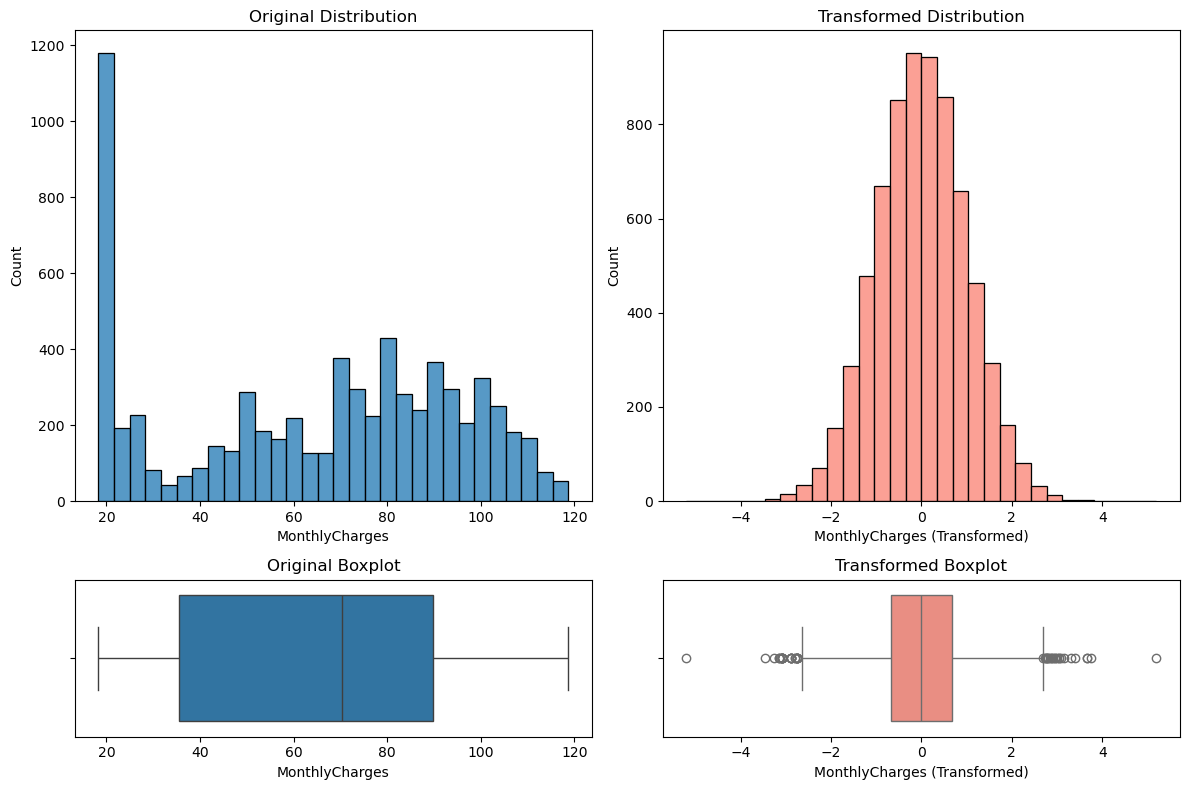

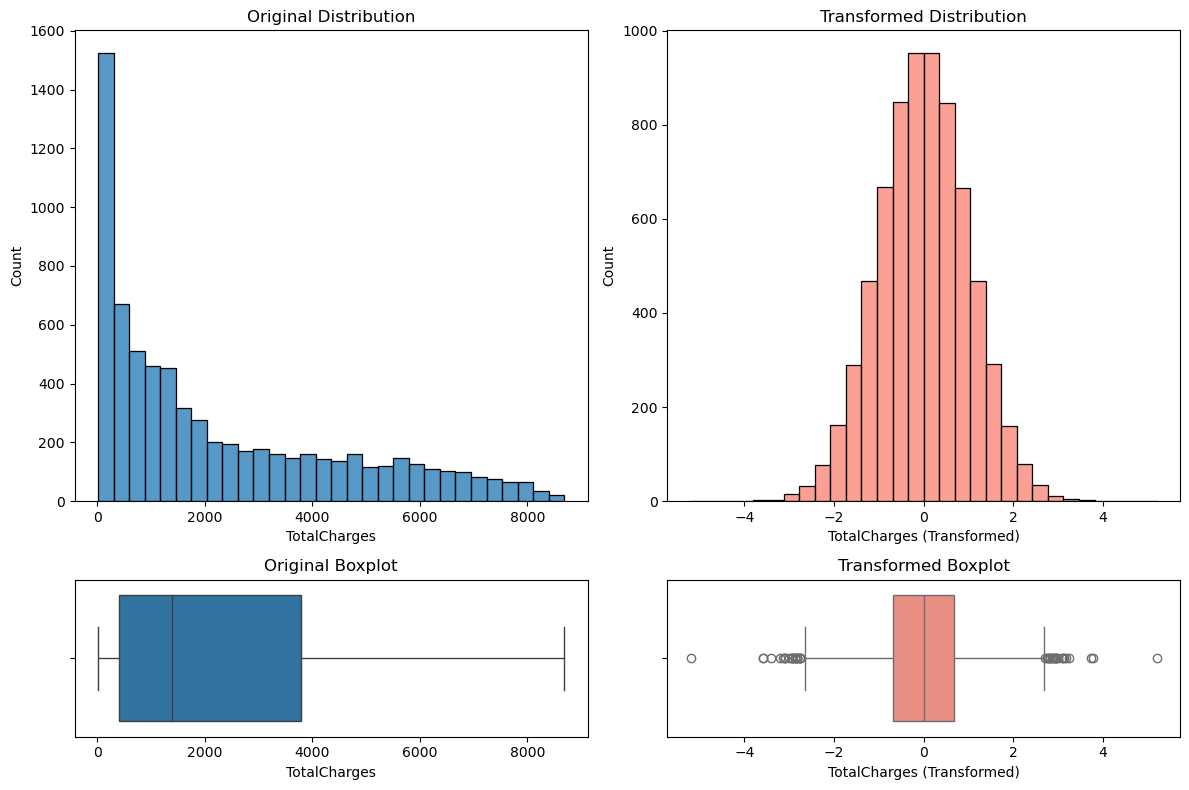

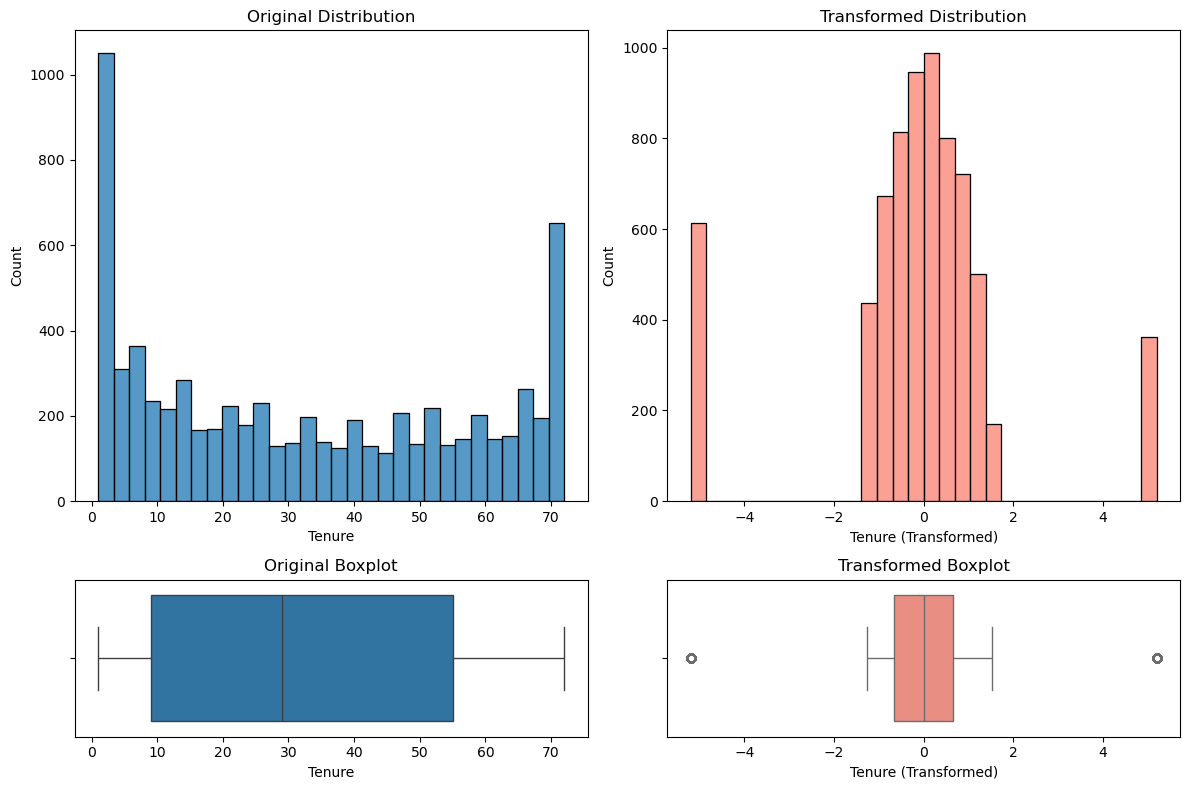

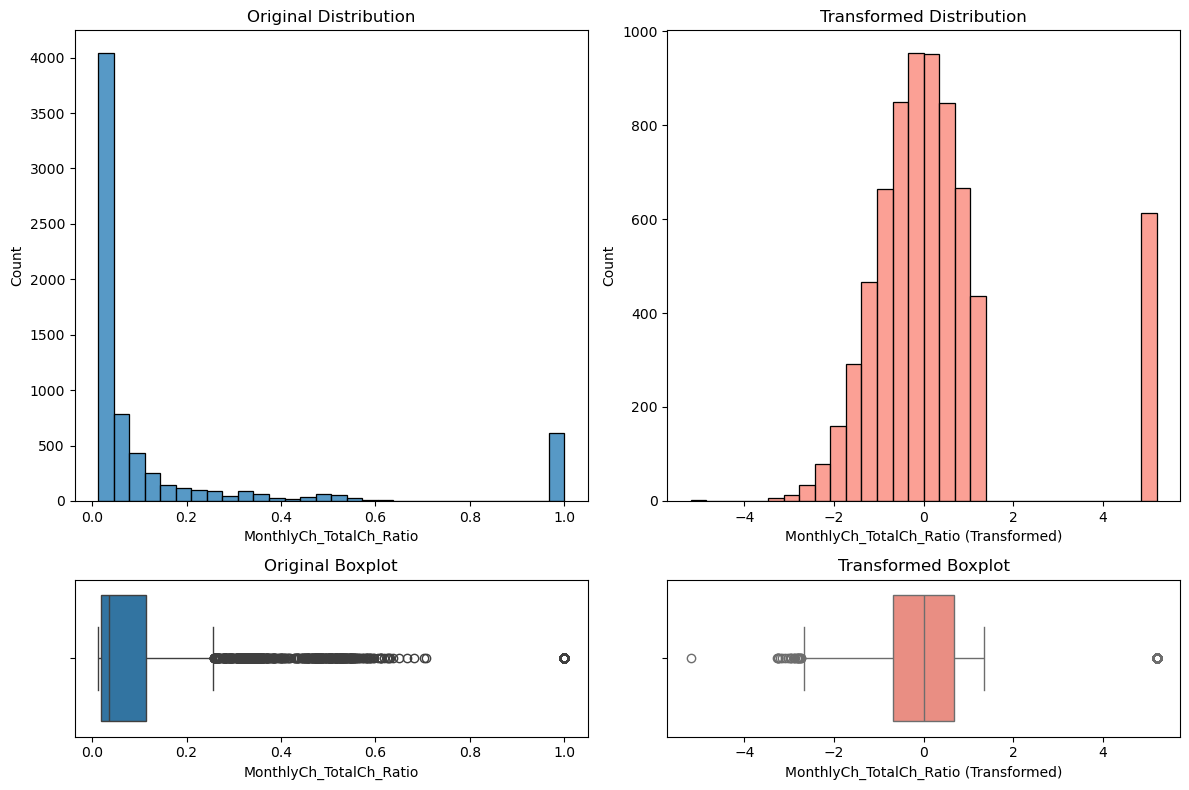

In [41]:
def apply_transformation(data, column, transformation='Quantile-Transform', 
                                  n_quantiles=1000, output_distribution='normal'):
    """
    Applies the specified transformation to a column in a dataset and plots the distribution 
    before and after the transformation, including histograms and boxplots.

    Parameters:
        data (pd.DataFrame): The dataset containing the original data.
        column (str): The column to be transformed.
        transformation (str): The transformation to apply ('Quantile-Transform', 'Box-cox', 'Yeo-Johnson').
        n_quantiles (int): Number of quantiles for QuantileTransformer (default 1000).
        output_distribution (str): Desired output distribution for QuantileTransformer ('uniform' or 'normal').

    Returns:
        np.array: The transformed column as a numpy array.
    """
    # Initial validation
    if column not in data.columns:
        raise ValueError(f"Column '{column}' not found in the dataset.")
    
    # Preserve original data
    original_data = data[column].dropna().values.reshape(-1, 1)

    # Apply the specified transformation
    if transformation == 'Quantile-Transform':
        transformer = QuantileTransformer(n_quantiles=n_quantiles, output_distribution=output_distribution, random_state=42)
        transformed_data = transformer.fit_transform(original_data)

    elif transformation == 'Box-cox':
        # Box-Cox requires positive values, so check if the column has any non-positive values
        if (original_data <= 0).any():
            raise ValueError("Box-Cox transformation requires strictly positive values.")
        transformer = PowerTransformer(method='box-cox')
        transformed_data = transformer.fit_transform(original_data)

    elif transformation == 'Yeo-Johnson':
        transformer = PowerTransformer(method='yeo-johnson')
        transformed_data = transformer.fit_transform(original_data)

    else:
        raise ValueError("Invalid transformation type. Choose from 'Quantile-Transform', 'Box-cox', or 'Yeo-Johnson'.")

    # Create a DataFrame for easy plotting
    df_plot = pd.DataFrame({
        'Original': original_data.flatten(),
        'Transformed': transformed_data.flatten()
    })
    
    # Create a figure with 2 rows and 2 columns
    fig, axes = plt.subplots(2, 2, figsize=(12, 8), gridspec_kw={'height_ratios': [3, 1]})
    
    # Histogram of original data
    sns.histplot(df_plot['Original'], bins=30, ax=axes[0, 0])
    axes[0, 0].set_title('Original Distribution')
    axes[0, 0].set_xlabel(column)
    
    # Histogram of transformed data
    sns.histplot(df_plot['Transformed'], bins=30, ax=axes[0, 1], color='salmon')
    axes[0, 1].set_title('Transformed Distribution')
    axes[0, 1].set_xlabel(f"{column} (Transformed)")
    
    # Boxplot of original data
    sns.boxplot(x=df_plot['Original'], ax=axes[1, 0])
    axes[1, 0].set_title('Original Boxplot')
    axes[1, 0].set_xlabel(column)
    
    # Boxplot of transformed data
    sns.boxplot(x=df_plot['Transformed'], ax=axes[1, 1], color='salmon')
    axes[1, 1].set_title('Transformed Boxplot')
    axes[1, 1].set_xlabel(f"{column} (Transformed)")
    
    # Adjust layout to avoid overlapping
    plt.tight_layout()
    plt.show()
    
    # Return the transformed data as a numpy array
    return transformed_data.flatten()

df_encoded['MonthlyCharges'] = apply_transformation(df_encoded, 'MonthlyCharges', output_distribution='normal', transformation='Quantile-Transform')
df_encoded['TotalCharges'] = apply_transformation(df_encoded, 'TotalCharges', output_distribution='normal', transformation='Quantile-Transform')
df_encoded['Tenure'] = apply_transformation(df_encoded, 'Tenure', output_distribution='normal', transformation='Quantile-Transform')
df_encoded['MonthlyCh_TotalCh_Ratio'] = apply_transformation(df_encoded, 'MonthlyCh_TotalCh_Ratio', output_distribution='normal', transformation='Quantile-Transform')

In [42]:
df_encoded.shape

(7032, 29)

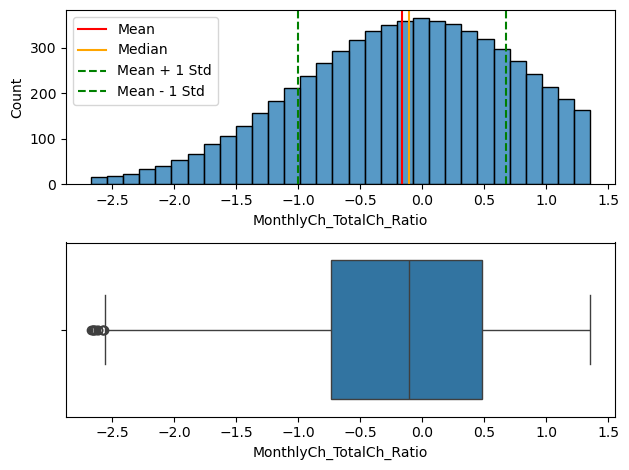

In [43]:
def remove_outliers(data,col):
    Q1 = data[col].quantile(0.25)
    Q3 = data[col].quantile(0.75)
    IQR = Q3 - Q1
    
    lower_limit = Q1 - 1.5*IQR
    upper_limit = Q3 + 1.5*IQR
    
    filter_ = (data[col] > lower_limit) & (data[col] < upper_limit)
    return data[filter_]

df_encoded = remove_outliers(df_encoded, 'MonthlyCh_TotalCh_Ratio')
df_encoded.explorer.numerical_dist('MonthlyCh_TotalCh_Ratio')
plt.show()

In [44]:
df_encoded.shape

(6395, 29)

/home/rey/anaconda3/envs/Telco/lib/python3.9/site-packages/scipy/stats/_axis_nan_policy.py:531: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 6395.
  res = hypotest_fun_out(*samples, **kwds)


Shapiro-Wilk Test: Statistic=0.9819, p-value=0.0000
D'Agostino and Pearson Test: Statistic=211.4242, p-value=0.0000
Shapiro-Wilk Test: Reject the null hypothesis (data is not normal).
D'Agostino and Pearson Test: Reject the null hypothesis (data is not normal).


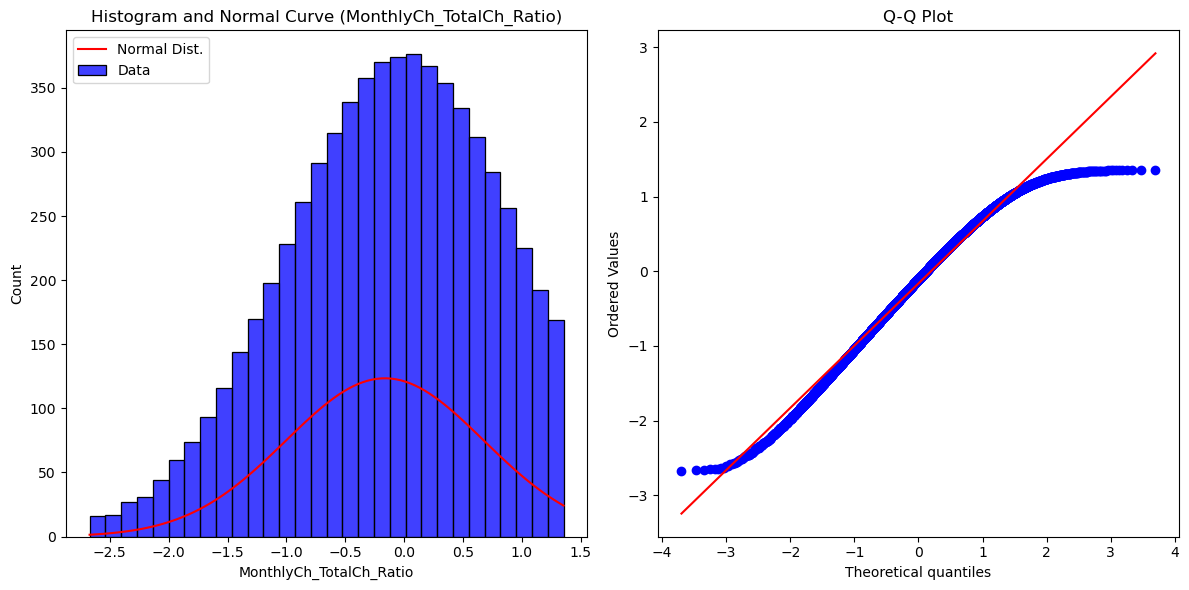

In [45]:
import scipy.stats as stats


def check_normality(data, column, significance_level=0.05):
    """
    Checks if a distribution is normal using statistical tests and visualizations.
    
    Parameters:
        data (pd.DataFrame): The dataset containing the column to test.
        column (str): The name of the column to test.
        significance_level (float): The significance level for the statistical tests (default 0.05).
    
    Returns:
        None: Prints the results of the normality tests and displays plots.
    """
    # Extract the data
    values = data[column].dropna()
    
    # Perform normality tests
    shapiro_stat, shapiro_p = stats.shapiro(values)
    dagostino_stat, dagostino_p = stats.normaltest(values)
    
    print(f"Shapiro-Wilk Test: Statistic={shapiro_stat:.4f}, p-value={shapiro_p:.4f}")
    print(f"D'Agostino and Pearson Test: Statistic={dagostino_stat:.4f}, p-value={dagostino_p:.4f}")
    
    # Interpret results
    if shapiro_p > significance_level:
        print("Shapiro-Wilk Test: Fail to reject the null hypothesis (data may be normal).")
    else:
        print("Shapiro-Wilk Test: Reject the null hypothesis (data is not normal).")
    
    if dagostino_p > significance_level:
        print("D'Agostino and Pearson Test: Fail to reject the null hypothesis (data may be normal).")
    else:
        print("D'Agostino and Pearson Test: Reject the null hypothesis (data is not normal).")
    
    # Plot histogram and Q-Q plot
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    
    # Histogram with normal distribution overlay
    sns.histplot(values, kde=False, bins=30, ax=axes[0], color="blue", label="Data")
    mu, std = np.mean(values), np.std(values)
    x = np.linspace(min(values), max(values), 100)
    axes[0].plot(x, stats.norm.pdf(x, mu, std) * len(values) * (x[1] - x[0]), color='red', label='Normal Dist.')
    axes[0].set_title(f"Histogram and Normal Curve ({column})")
    axes[0].legend()
    
    # Q-Q plot
    stats.probplot(values, dist="norm", plot=axes[1])
    axes[1].set_title("Q-Q Plot")
    
    plt.tight_layout()
    plt.show()
    

check_normality(df_encoded,'MonthlyCh_TotalCh_Ratio')


## Scaling Numerical Features to Values Between 0 and 1:


In [46]:
cols = ['Tenure','MonthlyCharges','TotalCharges','MonthlyCh_TotalCh_Ratio','MonthlyCh_TotalCh_Ratio_category']
scarler = MinMaxScaler()
scaled_df = df_encoded.copy()
scaled_df[cols] = scarler.fit_transform(df_encoded[cols])
scaled_df.head()

,SeniorCitizen,Tenure,MonthlyCharges,TotalCharges,Gender_Male,Partner_Yes,Dependents_Yes,PhoneService_Yes,MultipleLines_Yes,InternetService_DSL,...,Contract_One year,Contract_Two year,PaperlessBilling_Yes,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,Churn_Yes,MonthlyCh_TotalCh_Ratio,MonthlyCh_TotalCh_Ratio_category
customerID,,,,,,,,,,,,,,,,,,,,,
5575-GNVDE,0,0.213771,0.474009,0.297752,1,0,0,1,0,1,...,1,0,0,0,0,0,1,0,0.636663,0.333333
3668-QPYBK,0,0.000000,0.464128,0.103243,1,0,0,1,0,1,...,0,0,1,0,0,0,1,1,0.973478,1.000000
7795-CFOCW,0,0.253774,0.440426,0.295045,1,0,0,0,0,1,...,1,0,0,1,0,0,0,0,0.577512,0.333333
9237-HQITU,0,0.000000,0.501689,0.117720,0,0,0,1,0,0,...,0,0,1,0,0,1,0,1,0.963123,1.000000
9305-CDSKC,0,0.083626,0.606462,0.221537,0,0,0,1,1,0,...,0,0,1,0,0,1,0,1,0.839066,1.000000


### Correlation Analysis

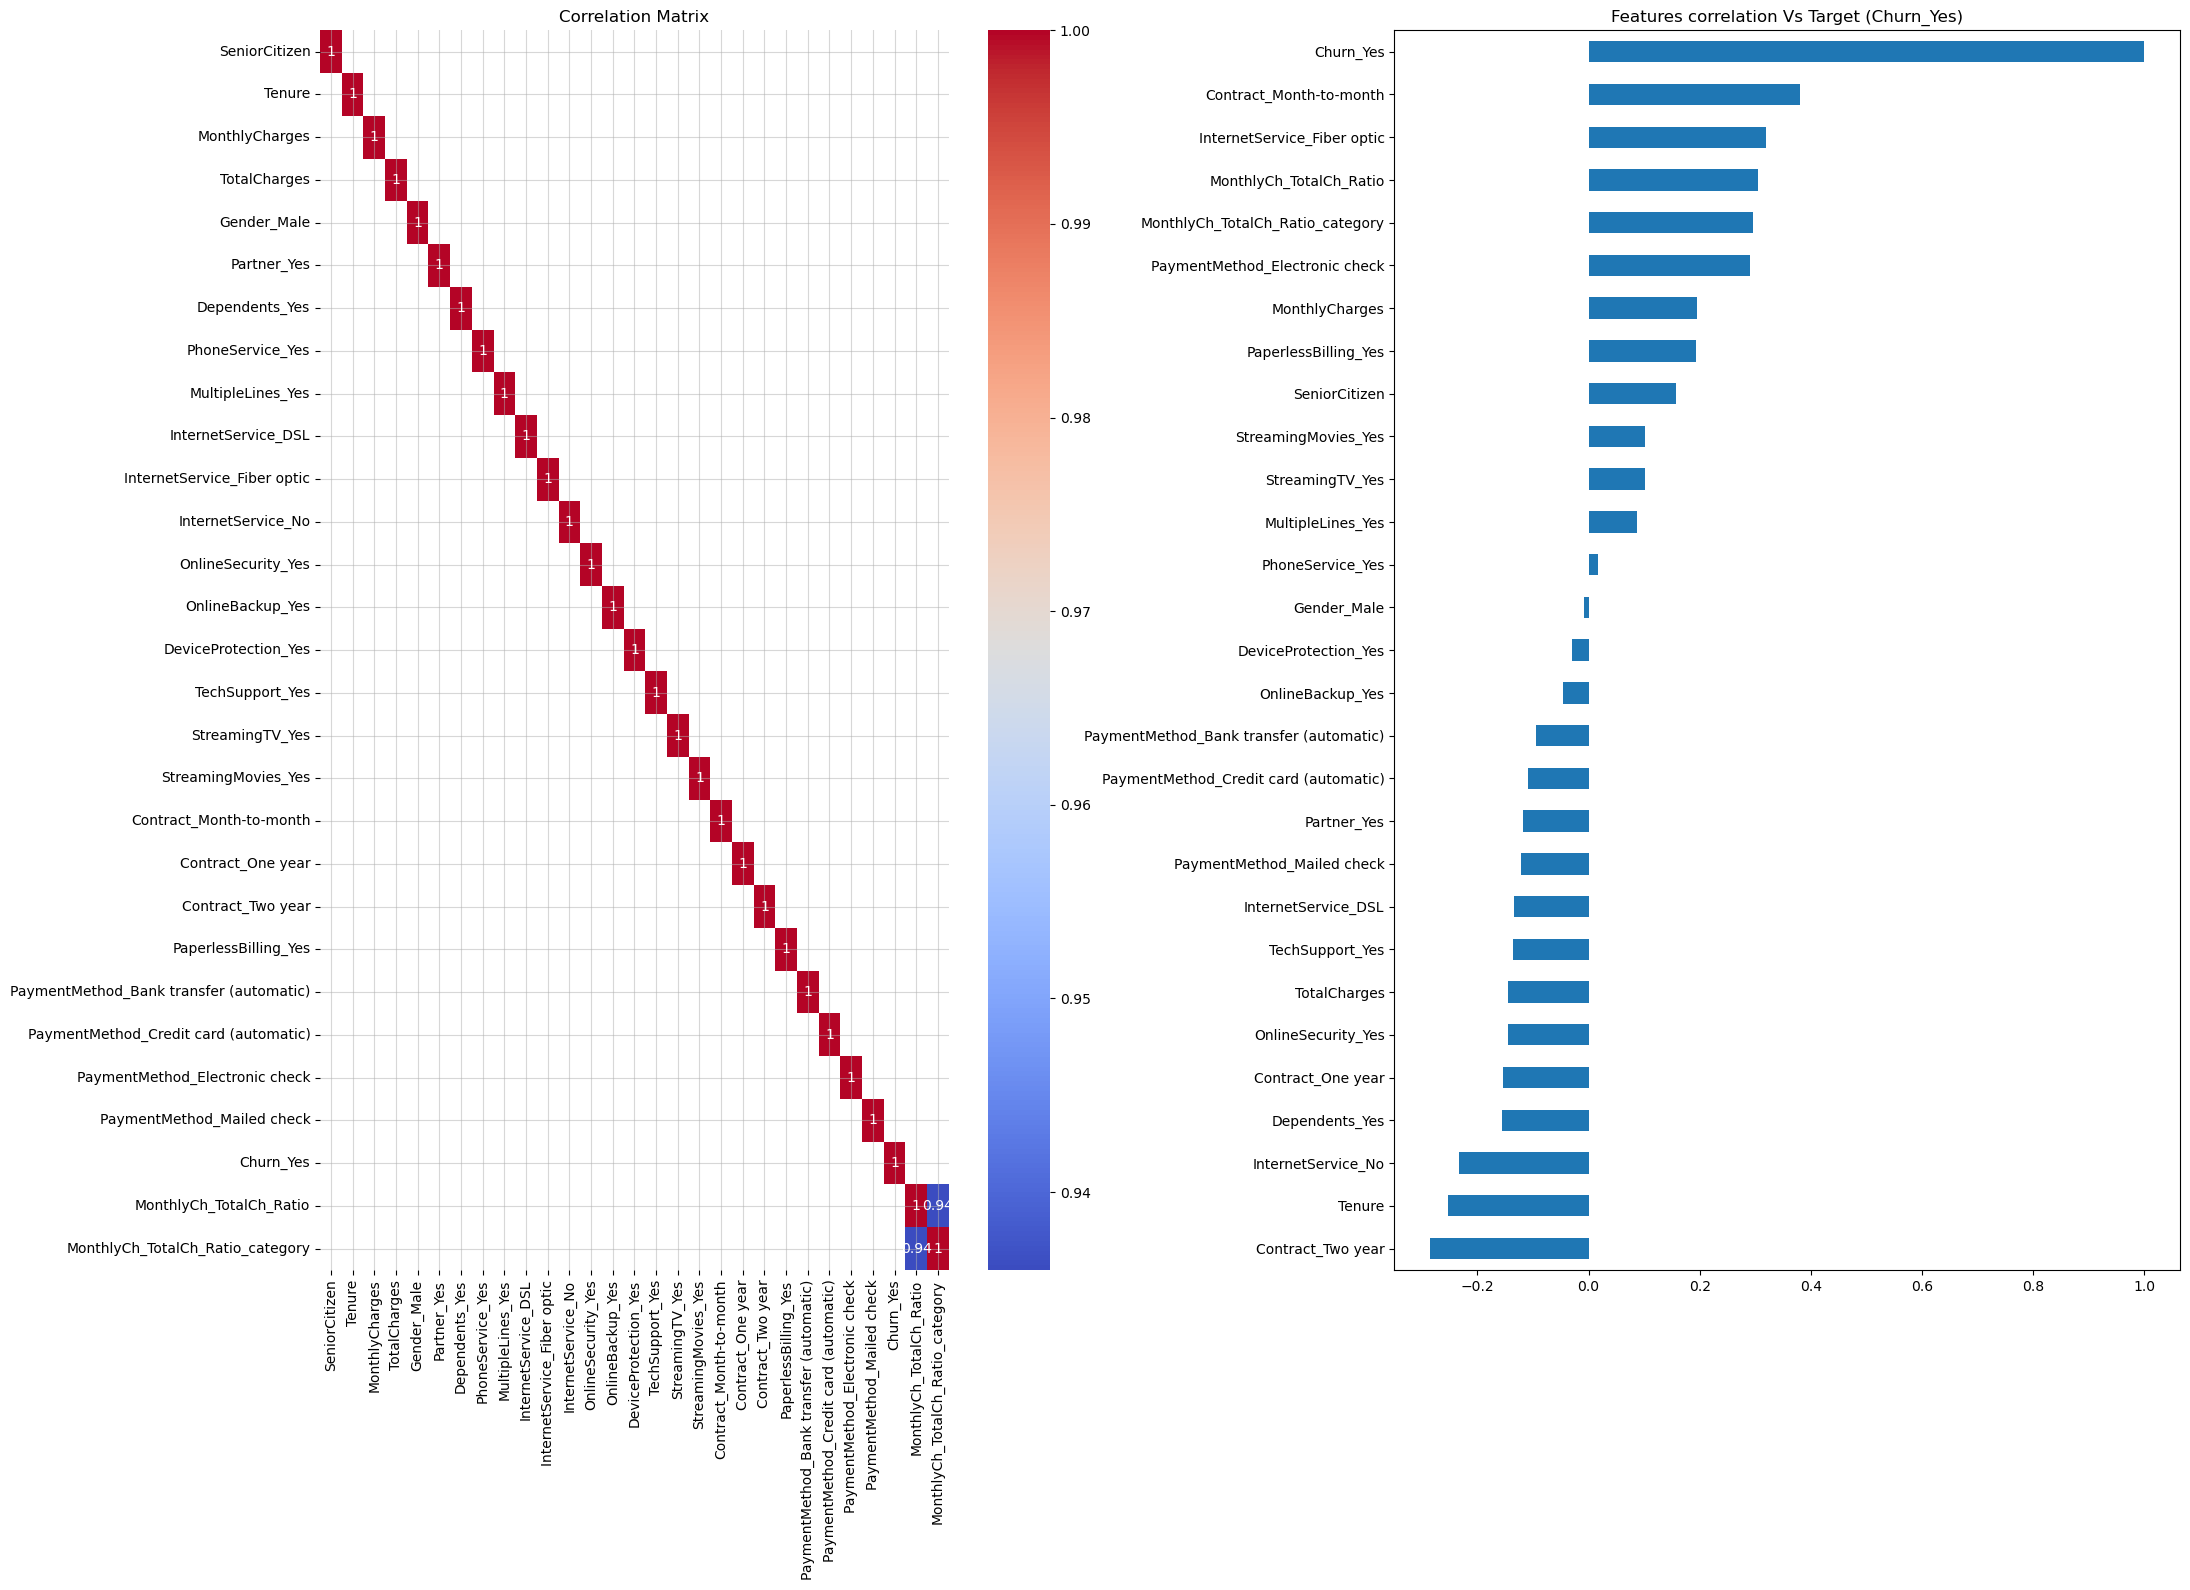

Correlated columns:
{'MonthlyCh_TotalCh_Ratio', 'MonthlyCh_TotalCh_Ratio_category'}.
Correlated pairs:
{('MonthlyCh_TotalCh_Ratio', 'MonthlyCh_TotalCh_Ratio_category')}


In [47]:

plt.figure(figsize=(22,16))
plt.subplot(1,2,1)
plt.title("Correlation Matrix")
sns.heatmap(scaled_df.corr()[abs(scaled_df.corr())>=0.9], cmap = 'coolwarm', annot=True)
plt.tight_layout()
plt.grid(alpha=0.5)
plt.subplot(1,2,2)
plt.title("Features correlation Vs Target (Churn_Yes)")
scaled_df.corr()['Churn_Yes'].sort_values(ascending=True).plot(kind='barh')
plt.tight_layout()
plt.show()

def correlation(dataset, threshold):
    col_corr = set()  # Set to store the pairs of correlated columns
    corr_pairs = set() # Set to store the pairs of correlated pairs
    corr_matrix = dataset.corr()
    
    for i in range(len(corr_matrix.columns)):
        for j in range(i + 1, len(corr_matrix.columns)):                # Compare all pairs of columns
            if abs(corr_matrix.iloc[i, j]) >= threshold:                # We are interested in absolute correlation values
                colname1 = corr_matrix.columns[i]                       # Getting the name of the first column
                colname2 = corr_matrix.columns[j]                       # Getting the name of the second column
                
                col_corr.add(colname1)  # Add correlated features to the set
                col_corr.add(colname2)  # Add correlated features to the set
                
                corr_pairs.add(tuple(sorted([colname1, colname2])))     # Add the pair of correlated columns as a tuple
                
    return col_corr, corr_pairs

# Call the function
col_corr, corr_pairs = correlation(scaled_df, 0.9)

# Print the correlated column pairs
print(f"Correlated columns:\n{col_corr}.\nCorrelated pairs:\n{corr_pairs}") 

## Features Selection

## Mutual Information Analysis, Correlation, Variance, Feature importancies analysis

In [48]:
# Splitting the dataframe into Features and target
X = scaled_df.drop(columns=['Churn_Yes'])
y = scaled_df['Churn_Yes']

# Getting the correlation values between features and target
corr_df = abs(scaled_df.corr()['Churn_Yes']).drop('Churn_Yes').to_frame()

# Getting mutual information for classification
mi_scores = mutual_info_classif(X,y, random_state=42)

# Creating a df with the MI scores
mi_df = pd.DataFrame({
    'Feature': X.columns,
    'Mutual_Information': mi_scores
})

# Calculate variances
var_df = scaled_df.var().to_frame().rename(columns={0:'Variance'})
var_df['Feature'] = var_df.index 

# Renaming columns
corr_df = corr_df.rename(columns={'Churn_Yes': 'Correlation'})
corr_df['Feature'] = corr_df.index  # Turning index into a column

# Fitting the model
rfc = RandomForestClassifier(random_state=42)
rfc.fit(X, y)

# Getting feature importancies
importances = rfc.feature_importances_

# Asociating importancies to the feature names
feature_importances = pd.DataFrame({
    'Feature': X.columns,
    'Importance': importances
})

# Sorting features by importancies
feature_importances = feature_importances.sort_values(by='Importance', ascending=False).reset_index(drop=True)

# Merging both dataframes using the features column
merged_df = pd.merge(mi_df, corr_df, on='Feature', how='inner')
merged_df = pd.merge(merged_df, var_df, on='Feature', how='inner')
merged_df = pd.merge(merged_df, feature_importances, on='Feature', how='inner')

# Scaling scores
scarler = MinMaxScaler()
cols = ['Mutual_Information','Correlation','Variance','Importance']
merged_df[cols] = scarler.fit_transform(merged_df[cols])

merged_df['Average_Score'] = (merged_df['Mutual_Information'] + merged_df['Correlation'] + merged_df['Variance'] + merged_df['Importance']) / 4
merged_df = merged_df.sort_values('Average_Score',ascending=False).reset_index(drop=True)
merged_df

,Feature,Mutual_Information,Correlation,Variance,Importance,Average_Score
0,Contract_Month-to-month,1.000000,1.000000,0.999469,0.363082,0.840638
1,InternetService_Fiber optic,0.592606,0.835048,0.988372,0.225900,0.660482
2,MonthlyCh_TotalCh_Ratio,0.627049,0.797094,0.141965,0.980062,0.636542
3,PaymentMethod_Electronic check,0.526956,0.758648,0.871490,0.178100,0.583798
4,Contract_Two year,0.632101,0.745678,0.759430,0.075411,0.553155
5,MonthlyCharges,0.568522,0.502427,0.000000,1.000000,0.517737
6,Tenure,0.553209,0.659417,0.146123,0.677801,0.509137
7,MonthlyCh_TotalCh_Ratio_category,0.542855,0.773160,0.483329,0.137503,0.484212
8,PaperlessBilling_Yes,0.211708,0.494861,0.962630,0.118347,0.446887
9,InternetService_No,0.471957,0.604733,0.648184,0.035751,0.440156


## Saving the feature scores table into a csv file: 

In [49]:
merged_df.to_csv('../telco_customer_churn/data/feature_scoring_table.csv',index=False)

## Saving the Preprocessed Dataset into a csv file

In [50]:
scaled_df.to_csv('../telco_customer_churn/data/preprocessed_dataset.csv',index=False)
print(scaled_df.shape)

(6395, 29)
